# RDC Model Training

This notebook trains the Radial Deformation Correction (RDC) model using synthetic datasets.

**Workflows:**
1. **Data Loading**: Loads pre-generated synthetic training data (X, Y) in meters.
2. **Model Architecture**: Builds a dense neural network for deformation correction.
3. **Training**: Optimizes the model using MSE loss and Adam optimizer.
4. **Evaluation**: Plots training history and evaluates model performance on validation data.

**Input**: `data/RDC/Synthetic_RDC`
**Output**: `Models/RDC`

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
#from sklearn.model_selection import train_test_split
import datetime

In [2]:
# --- Configuration ---
DATA_DIR = os.path.abspath('data/RDC/Synthetic_RDC/Array-64-0.052')
MODEL_SAVE_DIR = os.path.abspath('Models/RDC')
LOG_DIR = os.path.abspath('logs/rdc')

# Hyperparameters (from Paper)
INPUT_DIM = 64
HIDDEN_DIM = 64
OUTPUT_DIM = 64
NUM_HIDDEN_LAYERS = 3
LEARNING_RATE = 1e-4
BATCH_SIZE = 1400
EPOCHS = 1000
VALIDATION_SPLIT = 0.1 # ~15,000 / 150,000 samples


In [3]:
def load_dataset(data_dir):
    print("Loading dataset...")
    x_path = os.path.join(data_dir, 'X_train.npy')
    y_path = os.path.join(data_dir, 'Y_train.npy')
    
    if not os.path.exists(x_path) or not os.path.exists(y_path):
        raise FileNotFoundError(f"Data not found in {data_dir}")
    
    # Use Meters (Original Units)
    X = np.load(x_path)
    Y = np.load(y_path)
    
    print(f"Loaded X: {X.shape} (Units: Meters)")
    print(f"Loaded Y: {Y.shape} (Units: Meters)")
    # Shuffle the dataset
    print("Shuffling dataset...")
    indices = np.random.permutation(X.shape[0])
    X = X[indices]
    Y = Y[indices]

    return X, Y

In [4]:
def build_rdc_model(input_dim, hidden_dim, output_dim, num_hidden_layers, learning_rate):
    print("Building RDC Model...")
    model = models.Sequential()
    
    # Input Layer
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    
    # Hidden Layers
    for _ in range(num_hidden_layers):
        model.add(layers.Dense(hidden_dim, activation='relu'))
        
    # Output Layer
    model.add(layers.Dense(output_dim))
    
    # Compile
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    model.summary()
    return model

In [5]:
def train_model(model, X, Y, batch_size, epochs, val_split, log_dir, save_dir):
    print("Starting Training...")
    
    # Callbacks
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    checkpoint_path = os.path.join(save_dir, 'rdc_model_mm.h5')
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,
            patience=100,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=20,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=3)
    ]
    
    history = model.fit(
        X, Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=val_split,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [6]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    epochs_range = range(len(loss))

    plt.figure(figsize=(14, 6))

    # Plot Loss (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (MSE) [m^2]')
    plt.xlabel('Epochs')
    plt.ylabel('MSE (m^2)')
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, mae, label='Training MAE')
    plt.plot(epochs_range, val_mae, label='Validation MAE')
    plt.legend(loc='upper right')
    plt.title('Training and Validation MAE [m]')
    plt.xlabel('Epochs')
    plt.ylabel('MAE (m)')
    plt.grid(True)

    plt.show()

In [7]:
def evaluate_predictions(model, X, Y, num_samples=5):
    print("Evaluating sample predictions...")
    
    # Predict
    indices = np.random.choice(len(X), num_samples, replace=False)
    X_sample = X[indices]
    Y_sample = Y[indices]
    Y_pred = model.predict(X_sample)
    
    # Plot
    # Append first point to end to close the loop
    angles = np.linspace(0, 2*np.pi, 64, endpoint=False)
    angles = np.append(angles, angles[0])
    
    for i in range(num_samples):
        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, projection='polar')
        
        # Prepare data for closed loop plot
        x_plot = np.append(X_sample[i], X_sample[i][0])
        y_plot = np.append(Y_sample[i], Y_sample[i][0])
        pred_plot = np.append(Y_pred[i], Y_pred[i][0])
        
        # Input (Occluded)
        ax.plot(angles, x_plot, 'b-', label='Input (Occluded)', linewidth=1.5)
        
        # Target (Ground Truth)
        ax.plot(angles, y_plot, 'g--', label='Target (GT)', linewidth=1.5)
        
        # Prediction
        ax.plot(angles, pred_plot, 'r:', label='Prediction', linewidth=2)
        
        ax.set_title(f'Sample {indices[i]} (Units: Meters)')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.show()

In [8]:
def calculate_area_accuracy(model, X, Y):
    print("Calculating Mean Area Accuracy...")
    Y_pred = model.predict(X)
    
    # Calculate Area from Radial Distances (Polygon Formula)
    # Area = 0.5 * sum(r[i] * r[i+1] * sin(d_theta))
    k = Y.shape[1]
    d_theta = 2 * np.pi / k
    sin_d_theta = np.sin(d_theta)
    
    # We need to roll Y to get r[i+1]
    # Axis 1 is the radial dimension
    Y_rolled = np.roll(Y, -1, axis=1)
    Y_pred_rolled = np.roll(Y_pred, -1, axis=1)
    
    # Compute areas for all samples at once
    # Shape: (N, K) -> sum -> (N,)
    area_gt = 0.5 * np.sum(Y * Y_rolled * sin_d_theta, axis=1)
    area_pred = 0.5 * np.sum(Y_pred * Y_pred_rolled * sin_d_theta, axis=1)
    
    # Avoid division by zero
    area_gt = np.maximum(area_gt, 1e-10)
    area_pred = np.maximum(area_pred, 1e-10)
    
    # Calculate Ratio (Accuracy)
    # Acc = min(A_pred, A_gt) / max(A_pred, A_gt)
    accuracies = np.minimum(area_pred, area_gt) / np.maximum(area_pred, area_gt)
    
    mean_acc = np.mean(accuracies)
    print(f"Mean Area Accuracy: {mean_acc:.4f} ({mean_acc*100:.2f}%)")
    return mean_acc

In [9]:
# 1. Load Data
if os.path.exists(DATA_DIR):
    X, Y = load_dataset(DATA_DIR)
else:
    print(f"Data directory {DATA_DIR} does not exist. Please run rdc-data.ipynb first.")

Loading dataset...
Loaded X: (150122, 64) (Units: Meters)
Loaded Y: (150122, 64) (Units: Meters)
Shuffling dataset...


In [10]:
# 2. Build Model
model = build_rdc_model(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_hidden_layers=NUM_HIDDEN_LAYERS,
    learning_rate=LEARNING_RATE
)

Building RDC Model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
Total params: 16,640
Trainable params: 16,640
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 3. Train Model
log_dir = os.path.join(LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
history = train_model(
    model, X, Y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    val_split=VALIDATION_SPLIT,
    log_dir=log_dir,
    save_dir=MODEL_SAVE_DIR
)

Starting Training...
Epoch 1/1000
97/97 [==============================] - 1s 6ms/step - loss: 2.8581 - mae: 1.5203 - val_loss: 1.6284 - val_mae: 1.0576

Epoch 00001: val_loss improved from inf to 1.62841, saving model to e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\Models\RDC\rdc_model_mm.h5
Epoch 2/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.1461 - mae: 0.8370 - val_loss: 0.3224 - val_mae: 0.4097

Epoch 00002: val_loss improved from 1.62841 to 0.32240, saving model to e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\Models\RDC\rdc_model_mm.h5
Epoch 3/1000
97/97 [==============================] - 0s 4ms/step - loss: 0.2550 - mae: 0.3530 - val_loss: 0.1481 - val_mae: 0.2566

Epoch 00003: val_loss improved from 0.32240 to 0.14808, saving model to e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\Models\RDC\rdc_model_mm.h5
Epoch 4/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.1423 - 

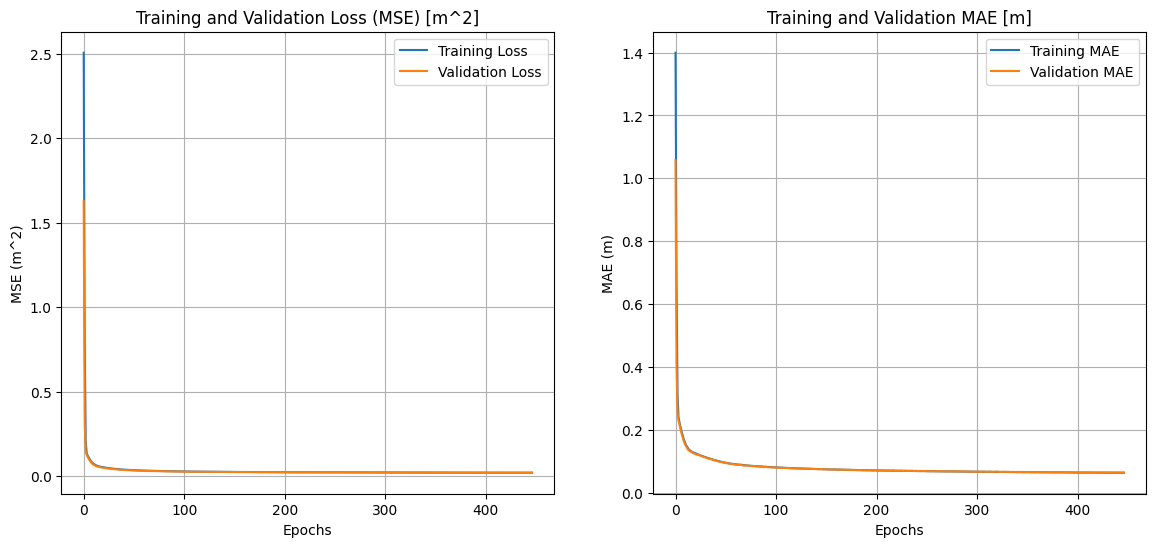

In [12]:
# 4. Visualize History
plot_training_history(history)

Evaluating sample predictions...


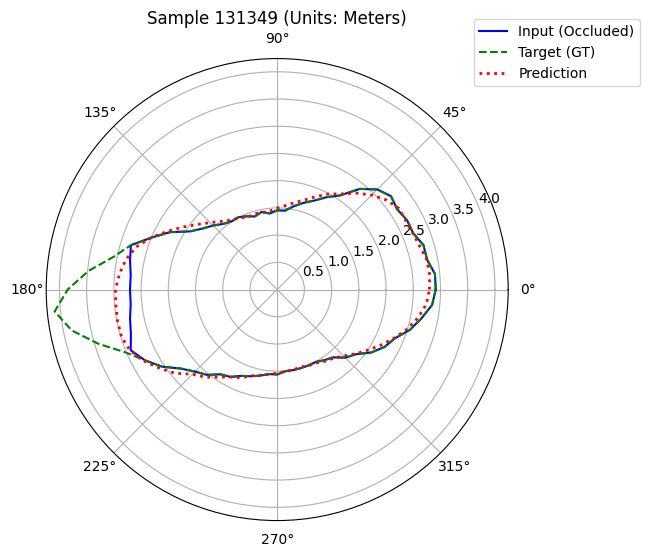

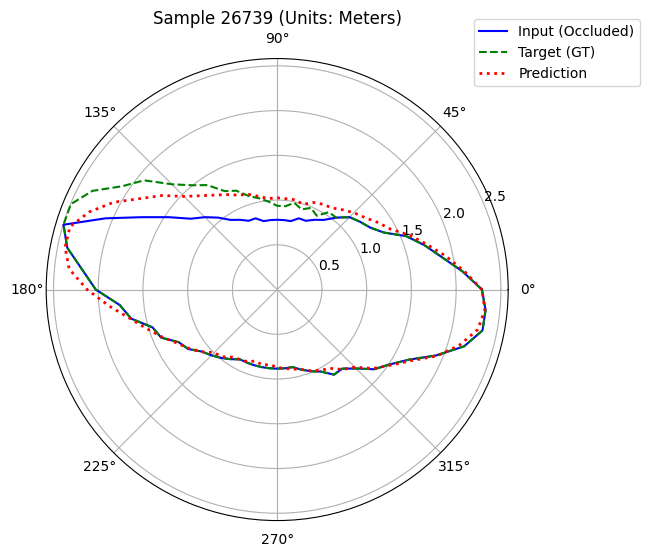

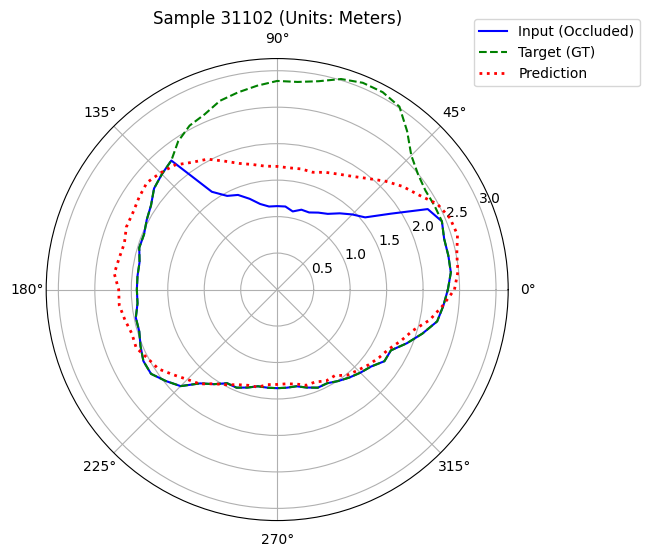

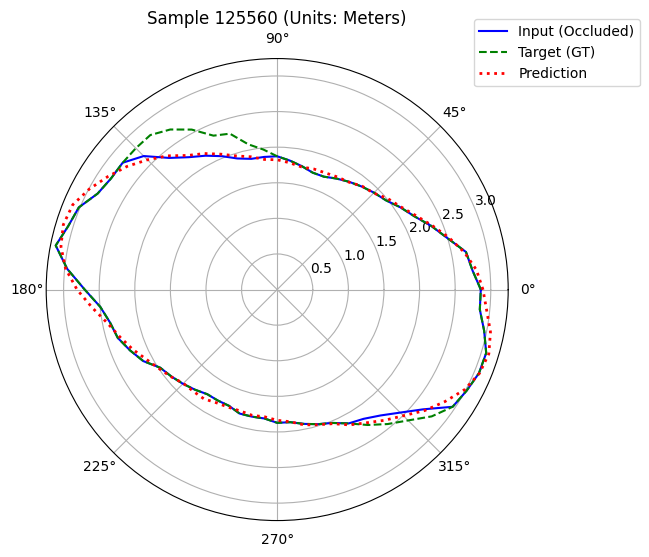

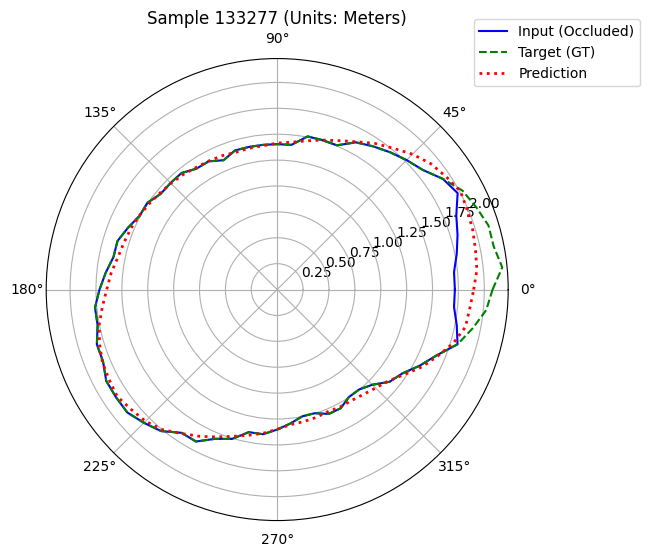

In [13]:
# 5. Visualize Predictions
evaluate_predictions(model, X, Y)

In [14]:
# 6. Calculate Accuracy
calculate_area_accuracy(model, X, Y)

Calculating Mean Area Accuracy...
Mean Area Accuracy: 0.9636 (96.36%)


0.9635580846461864